In [1]:
import time
from collections import Counter
import warnings; warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from tslearn.shapelets import ShapeletModel

import os
import sys
sys.path.append('../pyshapelets')
from extractors.extractor import MultiGeneticExtractor
from algorithms import ShapeletTransformer
import util

Using TensorFlow backend.


In [2]:
def grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_shapelets, l, r):
    base_size = int(l * ts_sz)
    d = {}
    for sz_idx in range(r):
        shp_sz = base_size * (sz_idx + 1)
        d[shp_sz] = n_shapelets
    return d

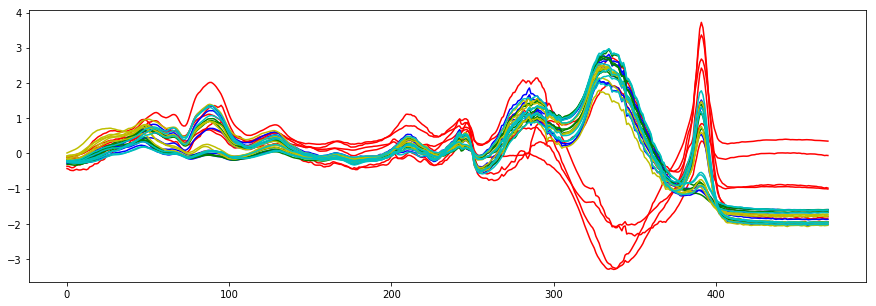

In [14]:
DATASET_NAME = 'Beef'
train_path = '../pyshapelets/data/partitioned/{}/{}_train.csv'.format(DATASET_NAME, DATASET_NAME)
test_path = '../pyshapelets/data/partitioned/{}/{}_test.csv'.format(DATASET_NAME, DATASET_NAME)
nr_shap, l, r, reg, max_it = [0.1, 0.2, 3, 0.01, 10]

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

cmap = {
    1: 'r',
    2: 'b',
    3: 'g',
    4: 'y',
    5: 'c'
}

plt.figure(figsize=(15,5))
for shap, label in zip(train_data.drop('target', axis=1).values, train_data['target'].values):
    plt.plot(shap, c=cmap[label])
plt.show()

X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

In [15]:
shapelet_dict = grabocka_params_to_shapelet_size_dict(
        X_train.shape[0], X_train.shape[1], int(nr_shap*X_train.shape[1]), l, r
)
clf = ShapeletModel(n_shapelets_per_size=shapelet_dict, 
                    max_iter=max_it, verbose_level=0, batch_size=8,
                    optimizer='sgd', weight_regularizer=reg)
clf.fit(
    np.reshape(
        X_train, 
        (X_train.shape[0], X_train.shape[1], 1)
    ), 
    y_train
)

ShapeletModel(batch_size=8, max_iter=10,
       n_shapelets_per_size={94: 47, 188: 47, 282: 47}, optimizer='sgd',
       verbose_level=0, weight_regularizer=0.01)

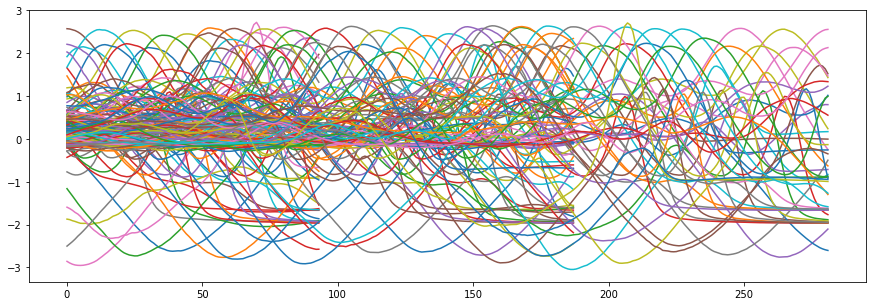

In [16]:
plt.figure(figsize=(15,5))
for shap in clf.shapelets_:
    plt.plot(shap)
plt.show()

In [17]:
genetic_extractor = MultiGeneticExtractor(verbose=True, population_size=25, wait=5, plot=False)
shap_transformer = ShapeletTransformer(method=genetic_extractor)
shap_transformer.fit(X_train, y_train)

it		avg		std		max		time
1		0.4136		0.089		0.52	3.1143
2		0.428		0.091		0.52	6.3498
3		0.456		0.075		0.52	6.9741
4		0.4752		0.068		0.52	5.1473
5		0.4632		0.087		0.56	7.4462
6		0.5088		0.06		0.56	7.6789
7		0.5336		0.048		0.56	8.9043
8		0.5584		0.005		0.56	8.8327
9		0.4944		0.102		0.56	9.0094


ShapeletTransformer(max_len=None, method=None, metric='ig', min_len=None,
          nr_shapelets=1)

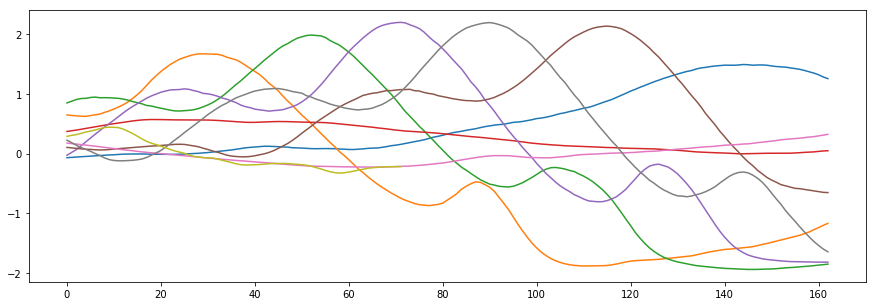

In [18]:
plt.figure(figsize=(15,5))
for shap in shap_transformer.shapelets:
    plt.plot(shap)
plt.show()

In [19]:
clf.transform(X_test[:5, :])[:, :5]

array([[0.10770173, 0.00689024, 0.00976514, 0.21895355, 0.01145756],
       [0.73394597, 0.11837393, 0.0246303 , 0.8922421 , 0.3450358 ],
       [0.5289282 , 0.10511129, 0.02454786, 0.5663913 , 0.16957594],
       [0.52432054, 0.10797098, 0.03414259, 0.26589218, 0.12166367],
       [0.765911  , 0.14797741, 0.00846181, 0.89877933, 0.48294958]],
      dtype=float32)

7783.345239037361 178


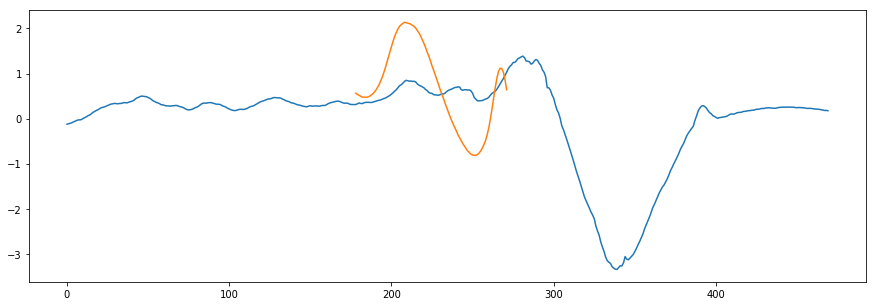

(377, 94)


0.7339458326291555

In [20]:
shapelet = clf.shapelets_[0]
sample = X_test[1, :]

def sdist_with_pos(x, y):
    if len(y) < len(x): return sdist(y, x)
    min_dist = np.inf
    best_pos = 0
    for j in range(len(y) - len(x) + 1):
        #norm_y = y[j:j+len(x)]
        dist = np.sum((x - y[j:j+len(x)])**2)
        if dist < min_dist:
            min_dist = dist
            best_pos = j
    return min_dist, best_pos

def local_square_dist(x, y):
    x_sq = np.reshape(np.sum(x ** 2, axis=1), (-1, 1))
    y_sq = np.reshape(np.sum(y ** 2), (1, 1, 1))
    xy = np.dot(x, y)
    return (x_sq + y_sq - 2 * xy) / len(y)

d, pos = sdist_with_pos(shapelet, sample)
print(d, pos)

plt.figure(figsize=(15,5))
plt.plot(sample)
plt.plot(range(pos, pos+len(shapelet)), shapelet)
plt.show()

# TODO: simplify this so that we dont need this for-loop!!!

steps = []
for i in range(len(sample) - len(shapelet) + 1):
    steps.append(sample[i:i+len(shapelet)])
steps = np.array(steps)
print(steps.shape)

# The distance between these two should be 0.15254669
np.min(local_square_dist(steps, shapelet))

In [21]:
377 * 141

53157